# Agglomerative Clustering Code

In [2]:
# Import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from collections import Counter
from sklearn.decomposition import PCA

import scipy
import scipy.cluster.vq
import scipy.spatial.distance
dst = scipy.spatial.distance.euclidean

# Import necessary modules for Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

# # Import necessary modules for k-modes clustering
from kmodes.kmodes import KModes

# Code below referenced from https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
# That's an impressive list of imports.
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

## Setting up data frame

In [3]:
# Grab dataframe containing police reports
# Create df on Macbook
# df = pd.read_csv("/Users/garrettyamane/Desktop/Springboard/capstone_project_1_data/merged.csv")

# Create df on PC
df = pd.read_csv("/Users/Garrett/Desktop/Springboard/capstone_project_1_data/merged.csv")
df = df.drop(columns='Unnamed: 0')

In [4]:
def label_hour(row):
    """Return either monring, afternoon, evening, or night depending on the hour of the day"""
    hour = int(row["Incident Hour"])
    if hour >= 5 and hour < 12: #5:00am to 11:59am
        return 'morning'
    elif hour >= 12 and hour < 17: #12:00pm to 4:59pm
        return 'afternoon'
    elif hour >= 17 and hour < 21: # 5:00pm to 8:59pm
        return 'evening'
    return 'night' # 9:00pm to 4:49am


def label_season(row):
    """Return either spring, summer, fall, or winter depending on the month of the year"""
    month = row["Incident Month"]
    spring = [3, 4, 5]
    summer = [6, 7, 8]
    fall = [9, 10, 11]
    winter = [12, 1, 2]
    
    if month in spring:
        return 'spring'
    elif month in summer:
        return 'summer'
    elif month in fall:
        return 'fall'
    return 'winter'

# Add "Hour" and "Month" columns
df["Incident Month"] = pd.to_datetime(df["Incident Date"]).dt.month
df["Incident Hour"] = df["Incident Time"].str.split(':').str[0]

# Add "season" and "time categories" columns
df['Time Category'] = df.apply(lambda row: label_hour(row), axis=1)
df['Season'] = df.apply(lambda row: label_season(row), axis=1)

In [5]:
# Crime Data Warehouse Data Frame
cdw_df = df[df["Incident Year"] > 2017].copy()
cdw_df["Incident Hour"] = cdw_df["Incident Hour"].astype(int)

In [6]:
# Create dummy variables for categorical crime features to be used for k-means model
dummies_df = pd.get_dummies(data=cdw_df, columns=["Incident Category", "Incident Day of Week", "Police District"])
columns = ["Incident Hour", "Incident Month", 'Incident Category_Arson', 'Incident Category_Assault',
       'Incident Category_Burglary', 'Incident Category_Case Closure',
       'Incident Category_Civil Sidewalks',
       'Incident Category_Courtesy Report',
       'Incident Category_Disorderly Conduct',
       'Incident Category_Drug Offense', 'Incident Category_Drug Violation',
       'Incident Category_Embezzlement', 'Incident Category_Family Offense',
       'Incident Category_Fire Report',
       'Incident Category_Forgery And Counterfeiting',
       'Incident Category_Fraud', 'Incident Category_Gambling',
       'Incident Category_Homicide',
       'Incident Category_Human Trafficking (A), Commercial Sex Acts',
       'Incident Category_Human Trafficking, Commercial Sex Acts',
       'Incident Category_Juvenile Offenses',
       'Incident Category_Larceny Theft', 'Incident Category_Liquor Laws',
       'Incident Category_Lost Property',
       'Incident Category_Malicious Mischief',
       'Incident Category_Miscellaneous Investigation',
       'Incident Category_Missing Person',
       'Incident Category_Motor Vehicle Theft',
       'Incident Category_Motor Vehicle Theft?',
       'Incident Category_Non-Criminal',
       'Incident Category_Offences Against The Family And Children',
       'Incident Category_Other', 'Incident Category_Other Miscellaneous',
       'Incident Category_Other Offenses', 'Incident Category_Prostitution',
       'Incident Category_Rape', 'Incident Category_Recovered Vehicle',
       'Incident Category_Robbery', 'Incident Category_Sex Offense',
       'Incident Category_Stolen Property', 'Incident Category_Suicide',
       'Incident Category_Suspicious', 'Incident Category_Suspicious Occ',
       'Incident Category_Traffic Collision',
       'Incident Category_Traffic Violation Arrest',
       'Incident Category_Vandalism', 'Incident Category_Vehicle Impounded',
       'Incident Category_Vehicle Misplaced', 'Incident Category_Warrant',
       'Incident Category_Weapons Carrying Etc',
       'Incident Category_Weapons Offence',
       'Incident Category_Weapons Offense', 'Incident Day of Week_Friday',
       'Incident Day of Week_Monday', 'Incident Day of Week_Saturday',
       'Incident Day of Week_Sunday', 'Incident Day of Week_Thursday',
       'Incident Day of Week_Tuesday', 'Incident Day of Week_Wednesday',
       'Police District_Bayview', 'Police District_Central',
       'Police District_Ingleside', 'Police District_Mission',
       'Police District_Northern', 'Police District_Out of SF',
       'Police District_Park', 'Police District_Richmond',
       'Police District_Southern', 'Police District_Taraval',
       'Police District_Tenderloin']
dummy_cols = dummies_df[columns]

# Convert dummy data frame to numpy array
dummy_np_arr = dummy_cols.to_numpy()

# Application of a new clustering algorithm: Agglomerative Clustering

I chose to use agglomerative propagation as another clustering algorithm because like k-means, agglomerative clustering requires a prior number of clusters to be known. However, I am curious to see how the 'hierarchical' clustering method can produce different cluster outputs compared to k-means, how different cluster numbers change the result of agglomerative clustering, and if any additional patterns can be discovered that k-means might not reveal.

In [7]:
# Scale dummy df
dummy_cols_scaled = pd.DataFrame(StandardScaler().fit_transform(dummy_cols), columns= columns)

# Get sample
agg_sample = dummy_cols_scaled.sample(10000, random_state=43)

C:\Users\Garrett\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Garrett\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [8]:
# Agglomerative Clustering with 2-10 clusters 
for k in range(2,11):
    agg = AgglomerativeClustering(n_clusters=k)
    agg.fit_predict(agg_sample)
    labels = agg.labels_
    score= silhouette_score(agg_sample, labels, metric='euclidean')
    print("The number of clusters: %d, silhouette coefficient: %0.2f" % (k,score))

The number of clusters: 2, silhouette coefficient: 0.71
The number of clusters: 3, silhouette coefficient: 0.71
The number of clusters: 4, silhouette coefficient: 0.71
The number of clusters: 5, silhouette coefficient: 0.71
The number of clusters: 6, silhouette coefficient: 0.68
The number of clusters: 7, silhouette coefficient: 0.39
The number of clusters: 8, silhouette coefficient: 0.39
The number of clusters: 9, silhouette coefficient: 0.40
The number of clusters: 10, silhouette coefficient: 0.02


## Agglomerative clustering model with 5 clusters

Using the silhouette method, it appears that after 5 clusters, the score goes down. Having a silhouette score of 0.71 tells me that a strong structure has been found and is worth investigating. I will now rebuild the agglomerative clustering model using n_clusters=5 (the same number of clusters as my baseline model) and compare my results to my k-means model. However, because the Crime Data Warehous data set contains more records than available memory can support, I will use the clustering on a subset of the data.

In [10]:
sample_df = cdw_df.reset_index().iloc[agg_sample.index, :]

In [11]:
# Build PCA model with 2 components, and fit the model to the police report data
pca = PCA(n_components = 2, random_state=42)
principal_components = pca.fit_transform(agg_sample.to_numpy())

# Assign principal components values as 'x' and 'y' coordinates for plot
xs = principal_components[:,0]
ys = principal_components[:,1]

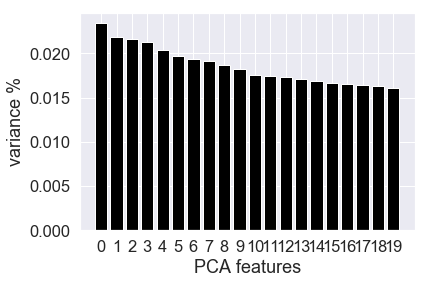

In [12]:
# Create a PCA instance: pca
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(agg_sample.to_numpy())
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

<Figure size 432x288 with 0 Axes>

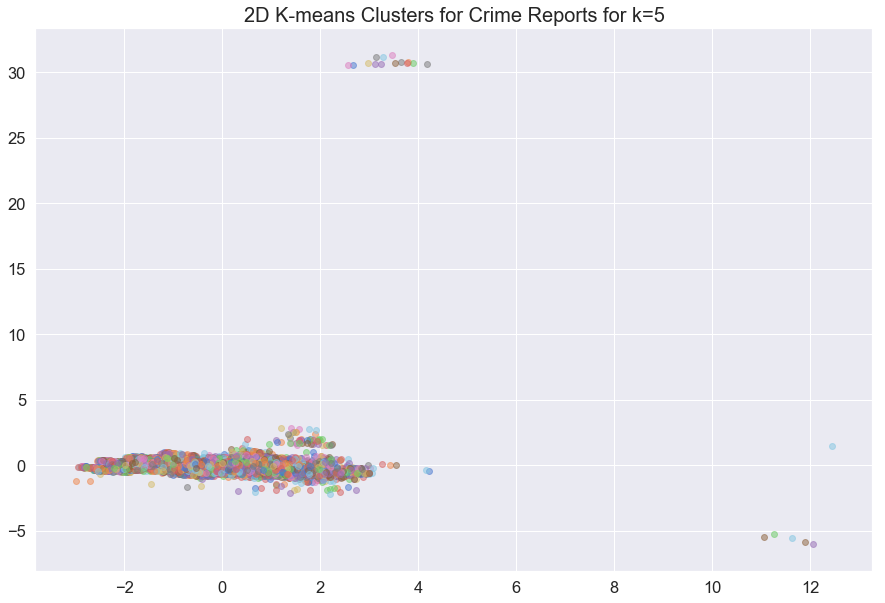

In [13]:
plt.clf()
plt.figure(figsize=(15,10))

for i in range(len(xs)):
    c0 = plt.scatter(xs[i], ys[i], alpha=0.5)
plt.title('2D K-means Clusters for Crime Reports for k=5', fontsize=20)

plt.show()

In [14]:
# Build agglomerative clustering model
agg = AgglomerativeClustering(n_clusters=5)
agg.fit_predict(agg_sample)
labels = agg.labels_

In [15]:
# Assign resulting cluster labels to 'cluster_id' column
sample_df["cluster_id"] = labels

# Assign cluster variables
c0 = sample_df[sample_df.cluster_id == 0]
c1 = sample_df[sample_df.cluster_id == 1]
c2 = sample_df[sample_df.cluster_id == 2]
c3 = sample_df[sample_df.cluster_id == 3]
c4 = sample_df[sample_df.cluster_id == 4]

### What types of crimes are in each cluster?

In [16]:
def top_8_pie(cluster):
    """Plots pie chart of top 5 categories per cluster"""
    
    top_8 = Counter(cluster["Incident Category"].tolist()).most_common(8)
    
    categories = [x[0] for x in top_8]
    values = [x[1] for x in top_8]
    other_val = len(cluster) - sum(values)
    
    # Get 'other' category for crimes not in top 8
    categories.append("Other")
    values.append(other_val)
    
    # Plot pie chart
    plt.pie(values, labels=categories, autopct='%1.1f%%', shadow=True, startangle=140, textprops={'fontsize': 12})
    plt.title("Cluster " + str(cluster.cluster_id.iloc[0]) + " Crime Classification % Distribution", fontsize=20)

    plt.axis('equal')

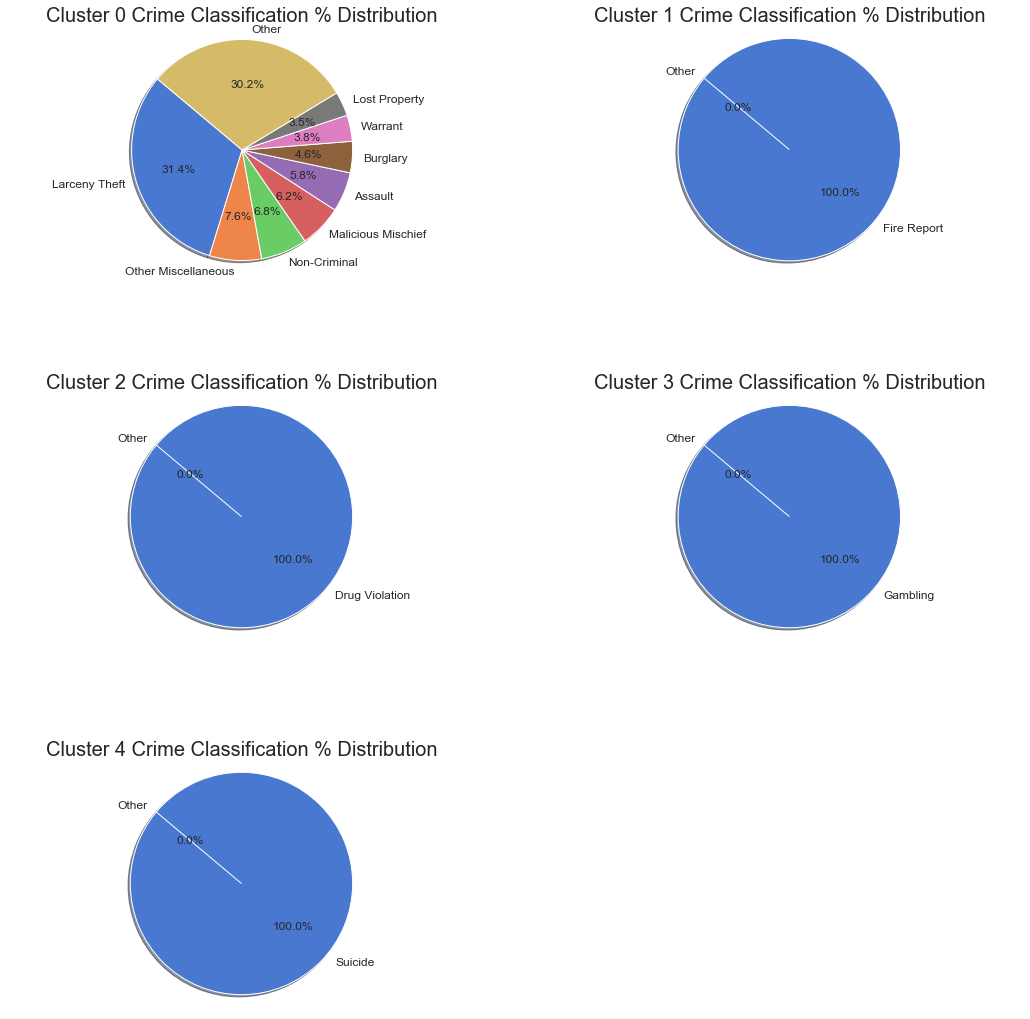

In [17]:
# Plot pie charts for each cluster's percentage distribution of crime classifications
fig = plt.figure(figsize=(18,18))
fig.subplots_adjust(hspace=.5)

plt.subplot2grid((3,2),(0,0))
top_8_pie(c0)
plt.subplot2grid((3,2),(0,1))
top_8_pie(c1)
plt.subplot2grid((3,2),(1,0))
top_8_pie(c2)
plt.subplot2grid((3,2),(1,1))
top_8_pie(c3)
plt.subplot2grid((3,2),(2,0))
top_8_pie(c4)